In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import sys
sys.path = ['..'] + sys.path

import tokenizers

%matplotlib inline

In [2]:
def join_with_tilde(s):
    return ' ~ '.join(s)

def join_lemmas_lists(r):
    result = []
    for row in r:
        result.extend(eval(row))
    return repr(result)

def join_with_tagged(output, tags):
    return (pd.merge(output, tags, on=['gameid', 'roundNum'])
              .query("sender == 'speaker'")[['gameid', 'roundNum', 'condition', 'outcome',
                                             'contents', 'lemmas', 'numSuper', 'numComp']]
              .groupby(['gameid', 'roundNum'])
              .agg({'condition': 'first', 'outcome': 'first',
                    'contents': join_with_tilde,
                    'lemmas': join_lemmas_lists,
                    'numSuper': 'sum', 'numComp': 'sum'})
              .reset_index())

In [4]:
TAGS_FILE = 'taggedColorMsgs.csv'
tags = pd.read_csv(TAGS_FILE, escapechar='\\')
tags.head()

,gameid,time,roundNum,sender,contents,lemmas,numSuper,numComp
0,1124-1,1459877203862,1,speaker,The darker blue one,"[(u'The', u'DT'), (u'darker', u'JJR'), (u'blue...",0,1
1,1124-1,1459877214034,2,speaker,purple,"[(u'purple', u'JJ')]",0,0
2,1124-1,1459877223719,3,speaker,Medium pink,"[(u'Medium', u'NN'), (u'pink', u'NN')]",0,0
3,1124-1,1459877227433,3,speaker,the medium dark one,"[(u'the', u'DT'), (u'medium', u'NN'), (u'dark'...",0,0
4,1124-1,1459877240480,4,speaker,lime,"[(u'lime', u'NN')]",0,0


In [5]:
CLICKS_FILE = 'humanOutput/colorReferenceClicks.csv'
h = join_with_tagged(pd.read_csv(CLICKS_FILE, escapechar='\\'), tags)
h.head()

,gameid,roundNum,numSuper,lemmas,condition,numComp,outcome,contents
0,0429-9,1,0,"[(u'the', u'DT'), (u'target', u'NN'), (u'a', u...",further,1,True,the target a brighter color ~ it is different ...
1,0429-9,2,0,"[(u'this', u'DT'), (u'color', u'NN'), (u'is', ...",equal,0,True,this color is often used in reference to someo...
2,0429-9,3,0,"[(u'this', u'DT'), (u'color', u'NN'), (u'is', ...",closer,0,True,this color is often used in reference to someo...
3,0429-9,4,0,"[(u'this', u'DT'), (u'is', u'VBZ'), (u'not', u...",further,0,True,this is not purple or gray
4,0429-9,5,0,"[(u'the', u'DT'), (u'color', u'NN'), (u'of', u...",equal,0,True,the color of whales


In [11]:
with open('tokenized.txt', 'w') as outfile:
    for row in h['contents'].head(100):
        outfile.write(' '.join(tokenizers.basic_unigram_tokenizer(row)) + '\n')

In [12]:
import kenlm
lm = kenlm.LanguageModel('kenlm.arpa')

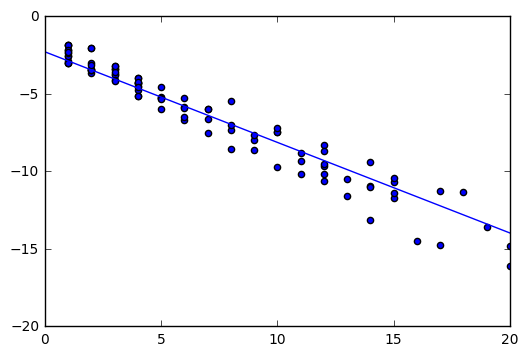

In [23]:
lens = []
scores = []

for row in h['contents'].head(100):
    tokd = tokenizers.basic_unigram_tokenizer(row)
    lens.append(len(tokd))
    scores.append(lm.score(' '.join(tokd)))

plt.scatter(lens, scores)
plt.xlim([0, 20])
plt.ylim([-20, 0])

a, b = np.polyfit(lens, scores, 1)
plt.plot([0., 20.], [b, 20. * a + b])

plt.show()

In [31]:
diffs = a * np.array(lens) + b - np.array(scores)
for diff, row in zip(np.sort(diffs), h['contents'][np.argsort(diffs)]):
    print('% 3.6f %s' % (diff, row))

-2.437961 bright lime green.~~~~~~the one that's brighter and more in your face~~~~~~~~~slightly yellower
-2.289375 I think the color on my screen is kind dulled down.~~~~~~sorry ~ this one is pink.~~~~~~lol~~~~~~~~~the most 'flesh colored' not sure how to describe it~~~~~~~~~not the kinda purple one, and not the redish one
-1.495502 not the blueish green or the lime green.~~~~~~ the mustardy green
-1.484008 fuschia.~~~~~~
-1.405071 lime green
-1.405071 lime green
-1.126041 trying to come up with descriptive enough clues :S ~ pink meets lavender.~~~~~~like old dirty pink maybe ~ yeah I'd go with that
-1.044635 blue.~~~~~~the brightest one ~ light blue
-1.040761 pink
-1.040761 pink
-1.040761 pink
-0.999604 camo green.~~~~~~think military fatigues
-0.929466 not the really pink or really blue.~~~~~~ the really purple
-0.904097 tan-ish.~~~~~~like slacks
-0.809384 bright light blue
-0.809384 bright light blue
-0.766819 oh this one is horrible! ~ go with murky.~~~~~~(*crosses fingers*)
-0.71

In [33]:
for score, row in zip(np.sort(scores), h['contents'][np.argsort(scores)]):
    print('% 3.6f %s' % (score, row))

-42.650558 I think the color on my screen is kind dulled down.~~~~~~sorry ~ this one is pink.~~~~~~lol~~~~~~~~~the most 'flesh colored' not sure how to describe it~~~~~~~~~not the kinda purple one, and not the redish one
-20.060873 not the brightest, but not the duller.~~~ the two are very similar and this one has more yellow than gray i suppose
-19.854040 trying to come up with descriptive enough clues :S ~ pink meets lavender.~~~~~~like old dirty pink maybe ~ yeah I'd go with that
-17.373346 bright lime green.~~~~~~the one that's brighter and more in your face~~~~~~~~~slightly yellower
-17.028492 not the purple purple, there are two that are closer to grey, this one has the most pink tones of those
-16.115604 not the really gray color, but of the two more purple colors the one with the least pink.
-14.953782 oh this one is horrible! ~ go with murky.~~~~~~(*crosses fingers*)
-14.821671 not the bright green green, there are two that are pukey colors and this is the brigher of them
-14.